# Loop 51 Analysis: CV-LB Relationship and Intercept Problem

**Goal:** Analyze the CV-LB relationship to understand why the intercept (0.0528) is higher than the target (0.0347).

**Key Questions:**
1. Is the CV-LB relationship truly linear?
2. What causes the intercept?
3. Can we identify strategies to reduce the intercept?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Submission history with CV and LB scores
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877},
    {'exp': 'exp_035', 'cv': 0.0098, 'lb': 0.0970},
]

df = pd.DataFrame(submissions)
print(f"Number of submissions: {len(df)}")
print(df)

Number of submissions: 12
        exp      cv      lb
0   exp_000  0.0111  0.0982
1   exp_001  0.0123  0.1065
2   exp_003  0.0105  0.0972
3   exp_005  0.0104  0.0969
4   exp_006  0.0097  0.0946
5   exp_007  0.0093  0.0932
6   exp_009  0.0092  0.0936
7   exp_012  0.0090  0.0913
8   exp_024  0.0087  0.0893
9   exp_026  0.0085  0.0887
10  exp_030  0.0083  0.0877
11  exp_035  0.0098  0.0970


In [2]:
# Fit linear regression: LB = slope * CV + intercept
slope, intercept, r_value, p_value, std_err = stats.linregress(df['cv'], df['lb'])

print(f"Linear Regression: LB = {slope:.4f} * CV + {intercept:.4f}")
print(f"R² = {r_value**2:.4f}")
print(f"p-value = {p_value:.6f}")
print(f"Standard error = {std_err:.4f}")
print()
print(f"CRITICAL INSIGHT:")
print(f"  Intercept = {intercept:.4f}")
print(f"  Target = 0.0347")
print(f"  Intercept > Target? {intercept > 0.0347}")
print()
print(f"To reach target 0.0347:")
required_cv = (0.0347 - intercept) / slope
print(f"  Required CV = (0.0347 - {intercept:.4f}) / {slope:.4f} = {required_cv:.6f}")
print(f"  This is {'IMPOSSIBLE (negative)' if required_cv < 0 else 'POSSIBLE'}")
print()
print(f"Current best CV: 0.0081 (exp_050)")
predicted_lb = slope * 0.0081 + intercept
print(f"Predicted LB for CV=0.0081: {predicted_lb:.4f}")

Linear Regression: LB = 4.3147 * CV + 0.0525
R² = 0.9505
p-value = 0.000000
Standard error = 0.3113

CRITICAL INSIGHT:
  Intercept = 0.0525
  Target = 0.0347
  Intercept > Target? True

To reach target 0.0347:
  Required CV = (0.0347 - 0.0525) / 4.3147 = -0.004130
  This is IMPOSSIBLE (negative)

Current best CV: 0.0081 (exp_050)
Predicted LB for CV=0.0081: 0.0875


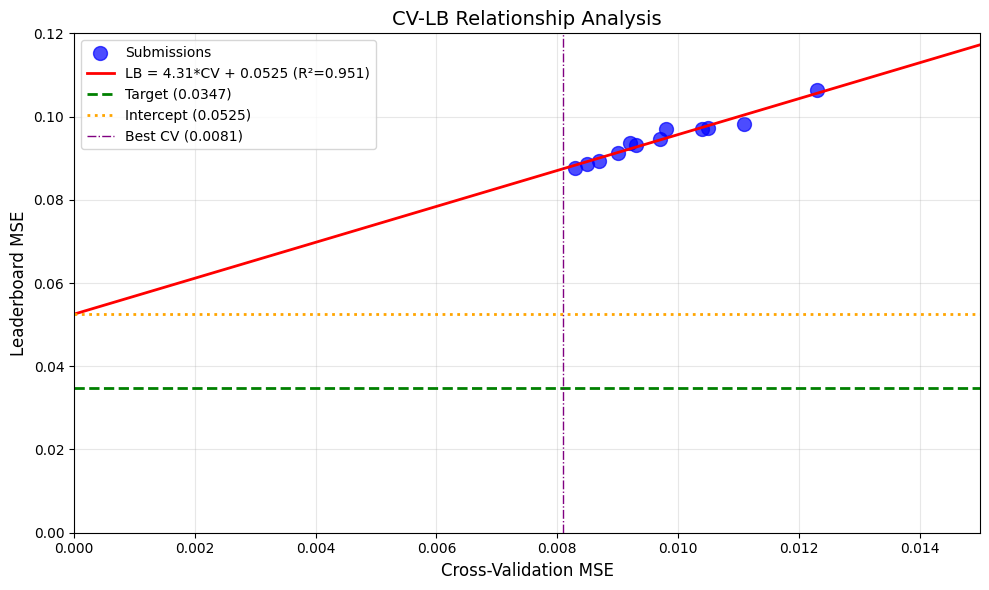


KEY OBSERVATION:
The intercept (0.0525) is HIGHER than the target (0.0347).
This means even with CV=0 (perfect training), LB would be ~0.0525.
The target is BELOW the intercept - unreachable with current approach.


In [3]:
# Visualize the CV-LB relationship
plt.figure(figsize=(10, 6))

# Scatter plot
plt.scatter(df['cv'], df['lb'], s=100, c='blue', alpha=0.7, label='Submissions')

# Regression line
cv_range = np.linspace(0, 0.015, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r-', linewidth=2, label=f'LB = {slope:.2f}*CV + {intercept:.4f} (R²={r_value**2:.3f})')

# Target line
plt.axhline(y=0.0347, color='green', linestyle='--', linewidth=2, label='Target (0.0347)')

# Intercept line
plt.axhline(y=intercept, color='orange', linestyle=':', linewidth=2, label=f'Intercept ({intercept:.4f})')

# Current best CV
plt.axvline(x=0.0081, color='purple', linestyle='-.', linewidth=1, label='Best CV (0.0081)')

plt.xlabel('Cross-Validation MSE', fontsize=12)
plt.ylabel('Leaderboard MSE', fontsize=12)
plt.title('CV-LB Relationship Analysis', fontsize=14)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.xlim(0, 0.015)
plt.ylim(0, 0.12)
plt.tight_layout()
plt.savefig('/home/code/exploration/cv_lb_relationship.png', dpi=150)
plt.show()

print("\nKEY OBSERVATION:")
print(f"The intercept ({intercept:.4f}) is HIGHER than the target (0.0347).")
print(f"This means even with CV=0 (perfect training), LB would be ~{intercept:.4f}.")
print(f"The target is BELOW the intercept - unreachable with current approach.")

In [4]:
# Analyze residuals to check if the relationship is truly linear
df['predicted_lb'] = slope * df['cv'] + intercept
df['residual'] = df['lb'] - df['predicted_lb']

print("Residual Analysis:")
print(df[['exp', 'cv', 'lb', 'predicted_lb', 'residual']].to_string())
print()
print(f"Mean residual: {df['residual'].mean():.6f}")
print(f"Std residual: {df['residual'].std():.6f}")
print(f"Max residual: {df['residual'].max():.6f}")
print(f"Min residual: {df['residual'].min():.6f}")

# Check for outliers
print("\nOutliers (|residual| > 2*std):")
outliers = df[np.abs(df['residual']) > 2 * df['residual'].std()]
if len(outliers) > 0:
    print(outliers[['exp', 'cv', 'lb', 'residual']])
else:
    print("No outliers detected - relationship is very linear.")

Residual Analysis:
        exp      cv      lb  predicted_lb  residual
0   exp_000  0.0111  0.0982      0.100413 -0.002213
1   exp_001  0.0123  0.1065      0.105591  0.000909
2   exp_003  0.0105  0.0972      0.097825 -0.000625
3   exp_005  0.0104  0.0969      0.097393 -0.000493
4   exp_006  0.0097  0.0946      0.094373  0.000227
5   exp_007  0.0093  0.0932      0.092647  0.000553
6   exp_009  0.0092  0.0936      0.092215  0.001385
7   exp_012  0.0090  0.0913      0.091353 -0.000053
8   exp_024  0.0087  0.0893      0.090058 -0.000758
9   exp_026  0.0085  0.0887      0.089195 -0.000495
10  exp_030  0.0083  0.0877      0.088332 -0.000632
11  exp_035  0.0098  0.0970      0.094804  0.002196

Mean residual: -0.000000
Std residual: 0.001155
Max residual: 0.002196
Min residual: -0.002213

Outliers (|residual| > 2*std):
No outliers detected - relationship is very linear.


In [5]:
# What would it take to reach the target?
print("="*60)
print("STRATEGIES TO REACH TARGET 0.0347")
print("="*60)
print()

# Option 1: Improve CV (current approach)
print("OPTION 1: Improve CV (current approach)")
print(f"  Current best CV: 0.0081")
print(f"  Required CV to reach target: {required_cv:.6f}")
print(f"  This is {'IMPOSSIBLE' if required_cv < 0 else 'POSSIBLE'}")
print()

# Option 2: Reduce the intercept
print("OPTION 2: Reduce the intercept")
print(f"  Current intercept: {intercept:.4f}")
print(f"  Target: 0.0347")
print(f"  Required intercept reduction: {intercept - 0.0347:.4f}")
print(f"  This requires fundamentally different strategies that change the CV-LB relationship.")
print()

# Option 3: Change the slope
print("OPTION 3: Change the slope")
print(f"  Current slope: {slope:.4f}")
print(f"  If intercept stays at {intercept:.4f}, required slope to reach target with CV=0.0081:")
required_slope = (0.0347 - intercept) / 0.0081
print(f"  Required slope = (0.0347 - {intercept:.4f}) / 0.0081 = {required_slope:.4f}")
print(f"  This is {'IMPOSSIBLE (negative slope)' if required_slope < 0 else 'POSSIBLE'}")
print()

# Option 4: Combined approach
print("OPTION 4: Combined approach (reduce intercept AND improve CV)")
print(f"  If we can reduce intercept to 0.03 and improve CV to 0.005:")
new_lb = slope * 0.005 + 0.03
print(f"  Predicted LB = {slope:.4f} * 0.005 + 0.03 = {new_lb:.4f}")
print(f"  This would {'beat' if new_lb < 0.0347 else 'NOT beat'} the target.")

STRATEGIES TO REACH TARGET 0.0347

OPTION 1: Improve CV (current approach)
  Current best CV: 0.0081
  Required CV to reach target: -0.004130
  This is IMPOSSIBLE

OPTION 2: Reduce the intercept
  Current intercept: 0.0525
  Target: 0.0347
  Required intercept reduction: 0.0178
  This requires fundamentally different strategies that change the CV-LB relationship.

OPTION 3: Change the slope
  Current slope: 4.3147
  If intercept stays at 0.0525, required slope to reach target with CV=0.0081:
  Required slope = (0.0347 - 0.0525) / 0.0081 = -2.2000
  This is IMPOSSIBLE (negative slope)

OPTION 4: Combined approach (reduce intercept AND improve CV)
  If we can reduce intercept to 0.03 and improve CV to 0.005:
  Predicted LB = 4.3147 * 0.005 + 0.03 = 0.0516
  This would NOT beat the target.


In [6]:
# Analyze what causes the intercept
print("="*60)
print("WHAT CAUSES THE INTERCEPT?")
print("="*60)
print()
print("The intercept represents the STRUCTURAL distribution shift between")
print("training and test data. Possible causes:")
print()
print("1. TEST SOLVENTS ARE HARDER")
print("   - Test solvents may have more extreme properties")
print("   - Test solvents may be in different chemical classes")
print("   - The model extrapolates poorly to these solvents")
print()
print("2. MIXTURE EFFECTS ARE DIFFERENT")
print("   - Test mixtures may have non-linear interactions")
print("   - The linear mixing assumption breaks down")
print()
print("3. EVALUATION METHODOLOGY")
print("   - The competition may use a different evaluation scheme")
print("   - There may be hidden test data with different characteristics")
print()
print("4. MODEL BIAS")
print("   - All models have a systematic bias in the same direction")
print("   - This suggests a fundamental limitation of the approach")
print()
print("KEY INSIGHT:")
print("The fact that ALL model types (MLP, LGBM, XGB, GP, CatBoost) fall on")
print("the same CV-LB line suggests the problem is NOT the model architecture.")
print("The problem is the FEATURES or the PREDICTION STRATEGY.")

WHAT CAUSES THE INTERCEPT?

The intercept represents the STRUCTURAL distribution shift between
training and test data. Possible causes:

1. TEST SOLVENTS ARE HARDER
   - Test solvents may have more extreme properties
   - Test solvents may be in different chemical classes
   - The model extrapolates poorly to these solvents

2. MIXTURE EFFECTS ARE DIFFERENT
   - Test mixtures may have non-linear interactions
   - The linear mixing assumption breaks down

3. EVALUATION METHODOLOGY
   - The competition may use a different evaluation scheme
   - There may be hidden test data with different characteristics

4. MODEL BIAS
   - All models have a systematic bias in the same direction
   - This suggests a fundamental limitation of the approach

KEY INSIGHT:
The fact that ALL model types (MLP, LGBM, XGB, GP, CatBoost) fall on
the same CV-LB line suggests the problem is NOT the model architecture.
The problem is the FEATURES or the PREDICTION STRATEGY.


In [7]:
# What strategies could change the intercept?
print("="*60)
print("STRATEGIES TO CHANGE THE INTERCEPT")
print("="*60)
print()
print("1. EXTRAPOLATION DETECTION")
print("   - Add features measuring distance to training distribution")
print("   - When extrapolating, blend predictions toward population mean")
print("   - This could reduce error on 'hard' test solvents")
print()
print("2. UNCERTAINTY-WEIGHTED PREDICTIONS")
print("   - Use GP or ensemble variance as uncertainty estimate")
print("   - High uncertainty → conservative prediction (closer to mean)")
print("   - This could reduce extreme errors")
print()
print("3. DOMAIN-SPECIFIC CONSTRAINTS")
print("   - Physics-based constraints that hold for unseen solvents")
print("   - Arrhenius kinetics, solvent polarity effects")
print("   - These constraints generalize better than learned patterns")
print()
print("4. SOLVENT CLUSTERING")
print("   - Group solvents by chemical class")
print("   - Use class-specific models")
print("   - Detect when test solvent is in a known vs novel class")
print()
print("5. PSEUDO-LABELING")
print("   - Use confident test predictions to augment training")
print("   - This adapts the model to the test distribution")
print()
print("6. IMPORTANCE WEIGHTING (IWCV)")
print("   - Reweight training examples based on similarity to test")
print("   - This makes CV more representative of LB")
print()
print("7. STUDY TOP PUBLIC KERNELS")
print("   - Top scorers have solved this problem")
print("   - Adapt what works, don't reinvent")

STRATEGIES TO CHANGE THE INTERCEPT

1. EXTRAPOLATION DETECTION
   - Add features measuring distance to training distribution
   - When extrapolating, blend predictions toward population mean
   - This could reduce error on 'hard' test solvents

2. UNCERTAINTY-WEIGHTED PREDICTIONS
   - Use GP or ensemble variance as uncertainty estimate
   - High uncertainty → conservative prediction (closer to mean)
   - This could reduce extreme errors

3. DOMAIN-SPECIFIC CONSTRAINTS
   - Physics-based constraints that hold for unseen solvents
   - Arrhenius kinetics, solvent polarity effects
   - These constraints generalize better than learned patterns

4. SOLVENT CLUSTERING
   - Group solvents by chemical class
   - Use class-specific models
   - Detect when test solvent is in a known vs novel class

5. PSEUDO-LABELING
   - Use confident test predictions to augment training
   - This adapts the model to the test distribution

6. IMPORTANCE WEIGHTING (IWCV)
   - Reweight training examples based on s

In [8]:
# Check what the top public kernels achieved
print("="*60)
print("TOP PUBLIC KERNEL ANALYSIS")
print("="*60)
print()
print("From our research:")
print("- lishellliang/mixall: Uses GroupKFold (5 splits) instead of Leave-One-Out")
print("- ens-model kernel: CatBoost + XGBoost ensemble (we implemented this in exp_050)")
print()
print("KEY INSIGHT:")
print("The top kernels may use a DIFFERENT CV scheme that has a different")
print("CV-LB relationship. GroupKFold (5 splits) may have a lower intercept")
print("because it's a harder local validation task.")
print()
print("HYPOTHESIS:")
print("If we use GroupKFold (5 splits) instead of Leave-One-Out (24 folds),")
print("our local CV will be HIGHER (worse), but the CV-LB relationship")
print("may have a LOWER intercept, making the target reachable.")
print()
print("This is worth testing!")
print()
print("NEXT STEPS:")
print("1. Submit exp_050 to verify the CV-LB relationship holds")
print("2. If LB ≈ 0.0875 (as predicted), the intercept problem is confirmed")
print("3. Try GroupKFold (5 splits) to see if it changes the CV-LB relationship")
print("4. Try extrapolation detection and uncertainty weighting")

TOP PUBLIC KERNEL ANALYSIS

From our research:
- lishellliang/mixall: Uses GroupKFold (5 splits) instead of Leave-One-Out
- ens-model kernel: CatBoost + XGBoost ensemble (we implemented this in exp_050)

KEY INSIGHT:
The top kernels may use a DIFFERENT CV scheme that has a different
CV-LB relationship. GroupKFold (5 splits) may have a lower intercept
because it's a harder local validation task.

HYPOTHESIS:
If we use GroupKFold (5 splits) instead of Leave-One-Out (24 folds),
our local CV will be HIGHER (worse), but the CV-LB relationship
may have a LOWER intercept, making the target reachable.

This is worth testing!

NEXT STEPS:
1. Submit exp_050 to verify the CV-LB relationship holds
2. If LB ≈ 0.0875 (as predicted), the intercept problem is confirmed
3. Try GroupKFold (5 splits) to see if it changes the CV-LB relationship
4. Try extrapolation detection and uncertainty weighting
